In [1]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

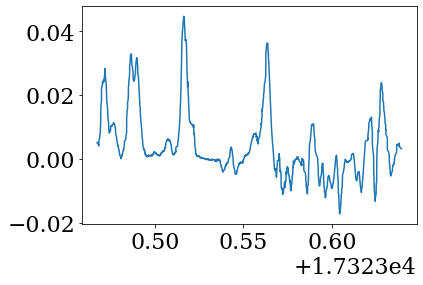

1706


In [9]:
#datafile = '20200428_scan2_unblocked_data.csv'
datafile = '20200428_scan2_173_background_subtracted_data.csv'

k = np.genfromtxt(datafile, delimiter=',')[1:,1]
a = np.genfromtxt(datafile, delimiter=',')[1:,2]

a = savgol_filter(a, 25, 3)

plt.plot(k, a)
plt.show()
print(len(a))

In [4]:
#Find peaks
threshold = .005
width = 20
peaks = []
for i in range(width,len(a)-width):
    if a[i]-threshold > a[i+width] and a[i]-threshold > a[i-width]:
        peaks.append(i)

#Average nearby peak locations (could maybe get width from this)
runs = [[]]
for i in range(1,len(peaks)):
    if peaks[i] == peaks[i-1]+1:
        runs[-1].append(peaks[i])
    else:
        runs.append([])
            
peaks = [int(mean(run)) for run in runs]
peak_widths = [len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty
k_peaks = np.array([k[i] for i in peaks])

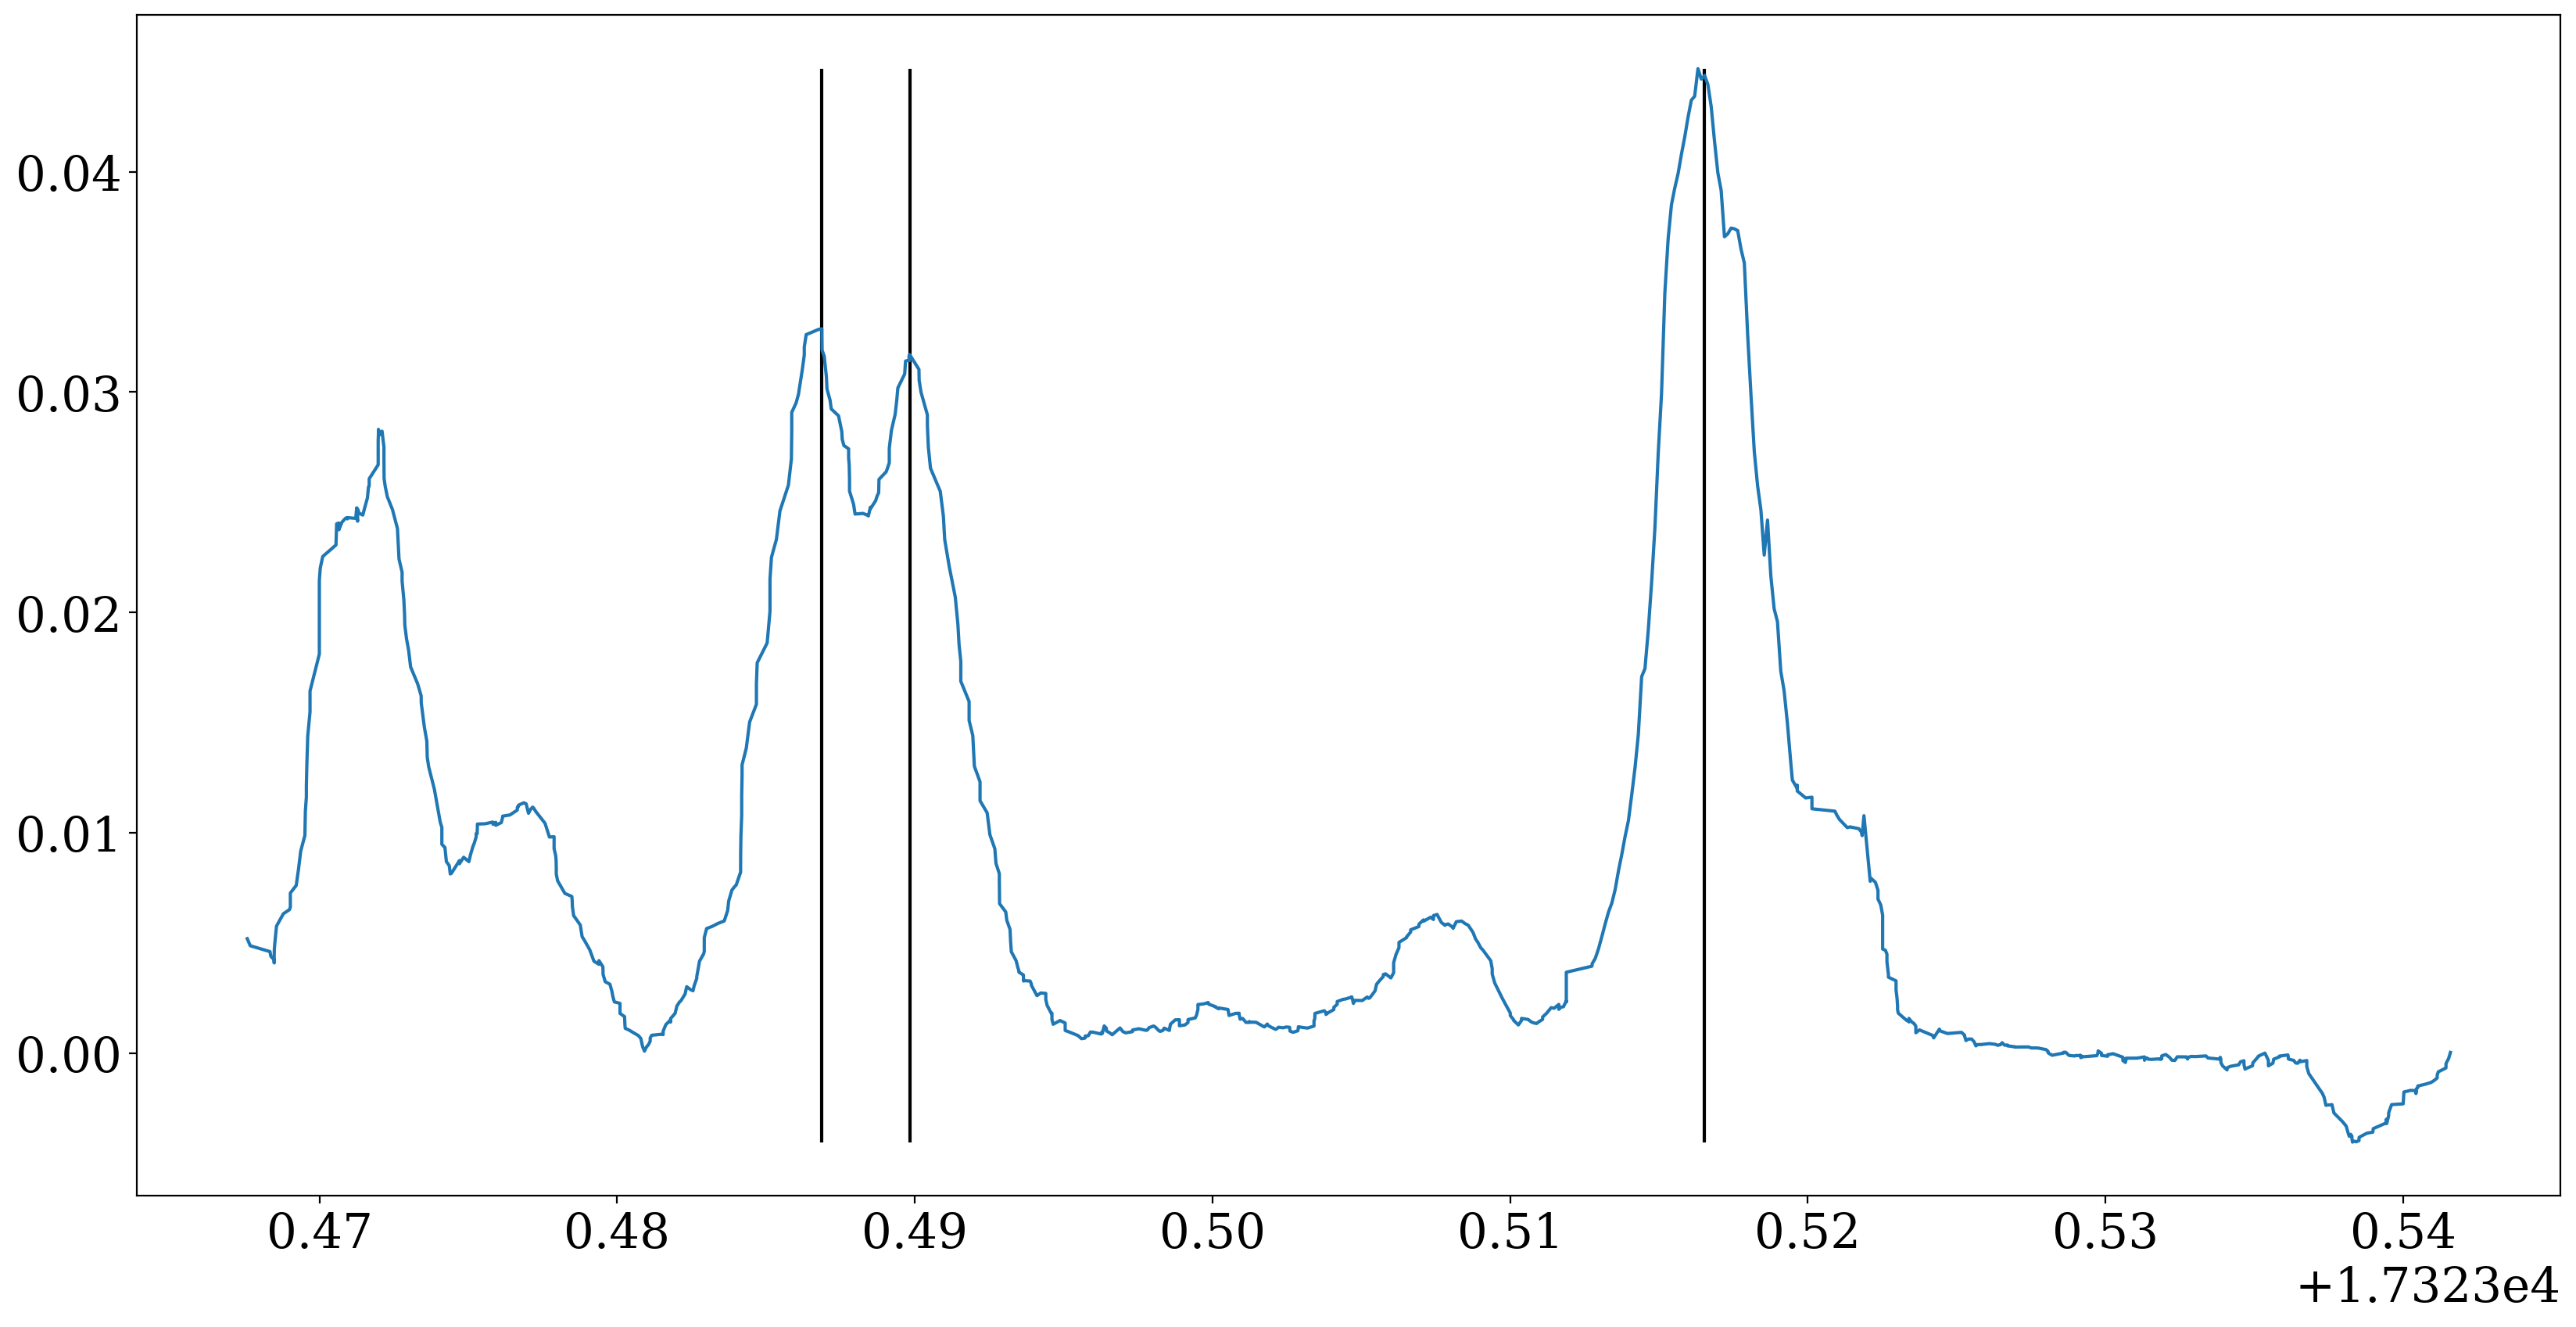

Line wavelengths: 0.48688054890953936, 0.4898292955404031, 0.5165338275874092
Line widths: 0.0008188331266865134, 0.0007164789858506992, 0.0014329579717013985


In [6]:
fig, ax = plt.subplots(figsize=(20, 10),dpi=200)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

ax.plot(k, a)
ax.vlines(k_peaks, np.min(a), np.max(a))

plt.show()
print("Line wavelengths: " + ', '.join(map(str,k_peaks-int(k_peaks[1]))))
print("Line widths: " + ', '.join(map(str,peak_widths)))